In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.impute import KNNImputer

In [ ]:
file_path = 'Dev_data_to_be_shared.csv'
df = pd.read_csv(file_path)
df_filtered = df.loc[~df.iloc[:, 2:].isnull().all(axis=1)]
output_path = 'empty_removed.csv'
df_filtered.to_csv(output_path, index=False)
df = pd.read_csv(output_path)

In [ ]:
from sklearn.impute import KNNImputer

def preprocess_and_fill_missing_values(file_path, output_path, fill_method="mean"):
    data = pd.read_csv(file_path)

    # Separate account number and target column from features
    account_number = data["account_number"]
    bad_flag = data["bad_flag"]
    features = data.drop(columns=["account_number", "bad_flag"])

    # Fill missing values
    if fill_method in ["mean", "median"]:
        for col in features.columns:
            if fill_method == "mean":
                features[col] = features[col].fillna(features[col].mean())
            elif fill_method == "median":
                features[col] = features[col].fillna(features[col].median())
    elif fill_method == "knn":
        imputer = KNNImputer(n_neighbors=5)
        features = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)

    # Reconstruct the final dataset
    processed_data = pd.concat([account_number, bad_flag, features], axis=1)

    # Save the processed dataset to a CSV file
    processed_data.to_csv(output_path, index=False)

    print(f"Processed dataset with missing values filled saved to: {output_path}")

# Example usage
file_path = "empty_removed.csv"  # Input file path
output_path = "processed_dataset.csv"  # Output file path
preprocess_and_fill_missing_values(file_path, output_path, fill_method="mean")


Processed dataset with missing values filled saved to: processed_dataset.csv


In [ ]:
def preprocess_and_fill_missing_values(file_path, output_path, fill_method="mean"):
    """
    Preprocess data to fill missing values in all columns.

    Args:
    - file_path: Path to the input CSV file.
    - output_path: Path to save the output CSV file with filled missing values.
    - fill_method: Method to handle missing values ('mean', 'median', or 'knn').

    Returns:
    - None. Saves the processed dataset as a CSV file.
    """
    # Load the dataset
    data = pd.read_csv(file_path)

    # Separate account number and target column from features
    account_number = data["account_number"]
    bad_flag = data["bad_flag"]
    features = data.drop(columns=["account_number", "bad_flag"])

    # Fill missing values
    if fill_method in ["mean", "median"]:
        for col in features.columns:
            if fill_method == "mean":
                features[col] = features[col].fillna(features[col].mean())
            elif fill_method == "median":
                features[col] = features[col].fillna(features[col].median())
    elif fill_method == "knn":
        imputer = KNNImputer(n_neighbors=5)
        features = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)

    # Reconstruct the final dataset
    processed_data = pd.concat([account_number, bad_flag, features], axis=1)

    # Save the processed dataset to a CSV file
    processed_data.to_csv(output_path, index=False)

    print(f"Processed dataset with missing values filled saved to: {output_path}")

# Example usage
file_path = "empty_removed.csv"  # Input file path
output_path = "processed_dataset.csv"  # Output file path
preprocess_and_fill_missing_values(file_path, output_path, fill_method="mean")

Processed dataset with missing values filled saved to: processed_dataset.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
def calculate_woe_iv(data, feature, target):
    """
    Calculate Weight of Evidence (WOE) and Information Value (IV) for a given feature.
    """
    # Bin continuous variables into 10 bins or fewer if unique values are less
    bins = pd.qcut(data[feature], q=10, duplicates='drop')
    grouped = data.groupby(bins, observed=False)

    # Calculate good and bad counts
    good = grouped[target].apply(lambda x: x[x == 0].count())
    bad = grouped[target].apply(lambda x: x[x == 1].count())
    total_good = good.sum()
    total_bad = bad.sum()

    # Avoid division by zero
    good_ratio = good / total_good
    bad_ratio = bad / total_bad
    bad_ratio = bad_ratio.replace(0, 0.0001)  # Replace 0 to avoid log(0)
    good_ratio = good_ratio.replace(0, 0.0001)

    # Calculate WOE and IV
    woe = np.log(good_ratio / bad_ratio)
    iv = (good_ratio - bad_ratio) * woe

    return woe, iv.sum()

def preprocess_and_select_features(file_path, target_column, fill_method="mean", n_remove=200):
    """
    Preprocess data and remove bottom N features based on IV.
    Args:
    - file_path: Path to the CSV file.
    - target_column: Name of the target column.
    - fill_method: Method to handle missing values ('mean', 'median', or 'knn').
    - n_remove: Number of least correlated features to remove.

    Returns:
    - DataFrame with selected features and IV scores.
    """
    # Load the dataset
    data = pd.read_csv(file_path)

    # Separate features and target
    target = data[target_column]
    features = data.drop(columns=[target_column])

    # Fill missing values
    if fill_method in ["mean", "median"]:
        for col in features.columns:
            if fill_method == "mean":
                features[col] = features[col].fillna(features[col].mean())
            elif fill_method == "median":
                features[col] = features[col].fillna(features[col].median())
    elif fill_method == "knn":
        imputer = KNNImputer(n_neighbors=5)
        features = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)

    # Calculate IV for each feature
    iv_scores = {}
    for col in features.columns:
        try:
            _, iv = calculate_woe_iv(pd.concat([features, target], axis=1), col, target_column)
            iv_scores[col] = iv
        except:
            # Handle cases where WOE cannot be calculated due to insufficient data
            iv_scores[col] = 0

    # Sort features by IV scores
    iv_sorted = sorted(iv_scores.items(), key=lambda x: x[1], reverse=True)

    # Select top features and remove the bottom N features
    selected_features = [feature for feature, iv in iv_sorted[:-n_remove]]
    reduced_data = features[selected_features]

    # Return the reduced DataFrame and IV scores for reference
    iv_df = pd.DataFrame(iv_sorted, columns=["Feature", "IV"])
    return reduced_data, iv_df

# Example usage:
file_path = "Dev_data_to_be_shared.csv"
target_column = "bad_flag"
reduced_data, iv_df = preprocess_and_select_features(file_path, target_column, fill_method="mean", n_remove=500)

# Save results
reduced_data.to_csv("reduced_dataset.csv", index=False)
iv_df.to_csv("iv_scores.csv", index=False)

print("Feature selection completed. Reduced data saved to 'reduced_dataset.csv'.")
print("Information values saved to 'iv_scores.csv'.")


Feature selection completed. Reduced data saved to 'reduced_dataset.csv'.
Information values saved to 'iv_scores.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

def calculate_woe_iv(data, feature, target):
    """
    Calculate Weight of Evidence (WOE) and Information Value (IV) for a given feature.
    """
    # Bin continuous variables into 10 bins or fewer if unique values are less
    bins = pd.qcut(data[feature], q=10, duplicates='drop')
    grouped = data.groupby(bins, observed=False)

    # Calculate good and bad counts
    good = grouped[target].apply(lambda x: x[x == 0].count())
    bad = grouped[target].apply(lambda x: x[x == 1].count())
    total_good = good.sum()
    total_bad = bad.sum()

    # Avoid division by zero
    good_ratio = good / total_good
    bad_ratio = bad / total_bad
    bad_ratio = bad_ratio.replace(0, 0.0001)  # Replace 0 to avoid log(0)
    good_ratio = good_ratio.replace(0, 0.0001)

    # Calculate WOE and IV
    woe = np.log(good_ratio / bad_ratio)
    iv = (good_ratio - bad_ratio) * woe

    return woe, iv.sum()

def preprocess_and_select_features(file_path, target_column, fill_method="mean", iv_threshold=0.01):
    """
    Preprocess data and select features based on IV threshold.
    Args:
    - file_path: Path to the CSV file.
    - target_column: Name of the target column.
    - fill_method: Method to handle missing values ('mean', 'median', or 'knn').
    - iv_threshold: Minimum IV score for a feature to be retained.

    Returns:
    - DataFrame with selected features and IV scores.
    """
    # Load the dataset
    data = pd.read_csv(file_path)

    # Separate features and target
    target = data[target_column]
    features = data.drop(columns=[target_column])

    # Fill missing values
    if fill_method in ["mean", "median"]:
        for col in features.columns:
            if fill_method == "mean":
                features[col] = features[col].fillna(features[col].mean())
            elif fill_method == "median":
                features[col] = features[col].fillna(features[col].median())
    elif fill_method == "knn":
        imputer = KNNImputer(n_neighbors=5)
        features = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)

    # Calculate IV for each feature
    iv_scores = {}
    for col in features.columns:
        try:
            _, iv = calculate_woe_iv(pd.concat([features, target], axis=1), col, target_column)
            iv_scores[col] = iv
        except:
            # Handle cases where WOE cannot be calculated due to insufficient data
            iv_scores[col] = 0

    # Filter features by IV threshold
    selected_features = [feature for feature, iv in iv_scores.items() if iv > iv_threshold]
    reduced_data = features[selected_features]

    # Return the reduced DataFrame and IV scores for reference
    iv_df = pd.DataFrame(iv_scores.items(), columns=["Feature", "IV"]).sort_values(by="IV", ascending=False)
    return reduced_data, iv_df

# Example usage:
file_path = "Dev_data_to_be_shared.csv"
target_column = "bad_flag"
reduced_data, iv_df = preprocess_and_select_features(file_path, target_column, fill_method="mean", iv_threshold=0.01)

# Save results
reduced_data.to_csv("reduced_dataset.csv", index=False)
iv_df.to_csv("iv_scores.csv", index=False)

print("Feature selection completed. Reduced data saved to 'reduced_dataset.csv'.")
print("Information values saved to 'iv_scores.csv'.")


In [ ]:
file_path = "reduced_dataset.csv"
reduced_data = pd.read_csv(file_path)
num_columns = reduced_data.shape[1]
print(f"The number of columns in the reduced dataset is: {num_columns}")

The number of columns in the reduced dataset is: 715


In [ ]:
import pandas as pd

# Read the CSV files
data1 = pd.read_csv('Dev_data_to_be_shared.csv')
data2 = pd.read_csv('reduced_dataset (2).csv')

# Ensure 'bad_flag' column exists in data1
if 'bad_flag' in data1.columns:
    # Add the 'bad_flag' column to data2
    data2['bad_flag'] = data1['bad_flag']

    # Save the updated data2.csv
    data2.to_csv('reduced_dataset (2).csv', index=False)
    print("Column 'bad_flag' has been added to data2.csv successfully.")
else:
    print("The column 'bad_flag' does not exist in data1.csv.")


Column 'bad_flag' has been added to data2.csv successfully.


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [ ]:
class AttentionNetwork(nn.Module):
    def __init__(self, n_features):
        """
        Initialize the attention mechanism to learn feature importance
        Args:
            n_features: Number of input features (excluding account number and bad_tag)
        """
        super().__init__()

        self.attention = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_features),
            nn.Softmax(dim=1)
        )

class NeuralPredictor(nn.Module):
    def __init__(self, n_features):

        super().__init__()

        self.predictor = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

class CreditDefaultPredictor:
    def __init__(self, predictor_type='neural_net', device='cuda' if torch.cuda.is_available() else 'cpu'):

        self.predictor_type = predictor_type
        self.device = device
        self.scaler = StandardScaler()

    def prepare_data(self, data_path):

        print("Loading data...")
        df = pd.read_csv(data_path)

        #account_numbers = df.iloc[:, 0]
        X = df.drop(columns=['bad_flag'])  # Replace with your target column
        y = df['bad_flag']


        print("Scaling features...")
        X_scaled = self.scaler.fit_transform(X)

        return X_scaled, y.values, X.columns

    def initialize_models(self, n_features):

        self.attention_net = AttentionNetwork(n_features).to(self.device)

        if self.predictor_type == 'neural_net':
            self.predictor = NeuralPredictor(n_features).to(self.device)
        else:
            self.predictor = RandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                random_state=42,
                n_jobs=-1
            )

    def train_neural_net(self, X_train, y_train, X_val, y_val,
                     epochs=100, batch_size=256, learning_rate=0.001):

        print("\nTraining Neural Network...")
        optimizer = optim.Adam(list(self.attention_net.parameters()) +
                              list(self.predictor.parameters()), lr=learning_rate)
        criterion = nn.BCELoss()

        X_train_tensor = torch.FloatTensor(X_train).to(self.device)
        y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1).to(self.device)
        X_val_tensor = torch.FloatTensor(X_val).to(self.device)
        y_val_tensor = torch.FloatTensor(y_val).reshape(-1, 1).to(self.device)

        for epoch in range(epochs):
            self.attention_net.train()
            self.predictor.train()

            for i in range(0, len(X_train), batch_size):
                batch_X = X_train_tensor[i:i+batch_size]
                batch_y = y_train_tensor[i:i+batch_size]

                optimizer.zero_grad()

                attention_weights = self.attention_net.attention(batch_X)
                weighted_features = batch_X * attention_weights
                predictions = self.predictor.predictor(weighted_features)

                loss = criterion(predictions, batch_y)

                l1_lambda = 0.01
                l1_reg = torch.norm(attention_weights, p=1)
                loss = loss + l1_lambda * l1_reg

                loss.backward()
                optimizer.step()

            self.attention_net.eval()
            self.predictor.eval()
            with torch.no_grad():
                val_attention_weights = self.attention_net.attention(X_val_tensor)
                val_weighted_features = X_val_tensor * val_attention_weights
                val_predictions = self.predictor.predictor(val_weighted_features)
                val_auc = roc_auc_score(y_val, val_predictions.cpu().numpy())

            print(f"Epoch {epoch+1}/{epochs}, Validation AUC: {val_auc:.4f}")


    def train_random_forest(self, X_train, y_train, X_val, y_val):

        print("\nTraining Random Forest...")
        temp_predictor = NeuralPredictor(X_train.shape[1]).to(self.device)
        optimizer = optim.Adam(list(self.attention_net.parameters()) +
                             list(temp_predictor.parameters()), lr=0.001)
        criterion = nn.BCELoss()

        X_train_tensor = torch.FloatTensor(X_train).to(self.device)
        y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1).to(self.device)

        # Train attention mechanism
        for epoch in range(10):
            optimizer.zero_grad()
            attention_weights = self.attention_net.attention(X_train_tensor)
            weighted_features = X_train_tensor * attention_weights
            temp_predictions = temp_predictor.predictor(weighted_features)
            loss = criterion(temp_predictions, y_train_tensor)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            attention_weights = self.attention_net.attention(X_train_tensor)
            weighted_features = (X_train_tensor * attention_weights).cpu().numpy()

        self.predictor.fit(weighted_features, y_train)

        X_val_tensor = torch.FloatTensor(X_val).to(self.device)
        with torch.no_grad():
            val_attention_weights = self.attention_net.attention(X_val_tensor)
            val_weighted_features = (X_val_tensor * val_attention_weights).cpu().numpy()
        val_predictions = self.predictor.predict_proba(val_weighted_features)[:, 1]
        val_auc = roc_auc_score(y_val, val_predictions)
        print(f"Validation AUC: {val_auc:.4f}")

    def predict(self, X):

        X_tensor = torch.FloatTensor(X).to(self.device)

        with torch.no_grad():
            attention_weights = self.attention_net.attention(X_tensor)
            weighted_features = X_tensor * attention_weights

            if self.predictor_type == 'neural_net':
                predictions = self.predictor.predictor(weighted_features)
                return predictions.cpu().numpy()
            else:
                weighted_features = weighted_features.cpu().numpy()
                return self.predictor.predict_proba(weighted_features)[:, 1]

    def get_feature_importance(self, feature_names, top_n=100, save_to_csv=True):

        dummy_input = torch.zeros((1, len(feature_names))).to(self.device)
        with torch.no_grad():
            attention_weights = self.attention_net.attention(dummy_input)

        importances = attention_weights.cpu().numpy().mean(axis=0)

        feature_analysis = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances,
            'Importance_Percentage': (importances / importances.sum()) * 100,
            'Cumulative_Importance': np.cumsum(np.sort(importances)[::-1] / importances.sum()) * 100
        })

        feature_analysis = feature_analysis.sort_values('Importance', ascending=False)

        top_features = feature_analysis.head(top_n)

        remaining_importance = feature_analysis.iloc[top_n:]['Importance_Percentage'].sum()

        print(f"\nTop {top_n} Feature Analysis:")
        print(f"These features account for {top_features['Importance_Percentage'].sum():.2f}% of total importance")
        print(f"Remaining {len(feature_names) - top_n} features account for {remaining_importance:.2f}%")

        if save_to_csv:
            top_features.to_csv('top_features_analysis.csv', index=False)
            print("\nDetailed analysis saved to 'top_features_analysis.csv'")

        plt.figure(figsize=(15, 8))
        plt.bar(range(top_n), top_features['Importance_Percentage'])
        plt.xlabel('Feature Rank')
        plt.ylabel('Importance (%)')
        plt.title(f'Top {top_n} Feature Importance Distribution')
        plt.tight_layout()
        plt.savefig('feature_importance_distribution.png')
        plt.close()

        return top_features.to_dict('records')

    def analyze_important_features(self, X, feature_names, top_n=100):

        top_features = self.get_feature_importance(feature_names, top_n=top_n)
        top_feature_names = [f['Feature'] for f in top_features]

        X_df = pd.DataFrame(X, columns=feature_names)
        analysis_df = pd.DataFrame()

        for feature in top_feature_names:
            feature_stats = {
                'Feature': feature,
                'Mean': X_df[feature].mean(),
                'Std': X_df[feature].std(),
                'Min': X_df[feature].min(),
                'Max': X_df[feature].max(),
                'Missing_Percentage': (X_df[feature].isna().sum() / len(X_df)) * 100,
                'Zero_Percentage': (X_df[feature] == 0).sum() / len(X_df) * 100
            }
            analysis_df = pd.concat([analysis_df, pd.DataFrame([feature_stats])], ignore_index=True)

        analysis_df.to_csv('important_features_statistics.csv', index=False)
        print("\nDetailed feature statistics saved to 'important_features_statistics.csv'")

        return analysis_df

def main():

    model = CreditDefaultPredictor(predictor_type='neural_net')  # random_forest or neural_net can be used

    X, y, feature_names = model.prepare_data('reduced_dataset (2).csv')

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    model.initialize_models(X.shape[1])

    if model.predictor_type == 'neural_net':
        model.train_neural_net(X_train, y_train, X_val, y_val)
    else:
        model.train_random_forest(X_train, y_train, X_val, y_val)

    # Make predictions
    test_predictions = model.predict(X_test)
    test_auc = roc_auc_score(y_test, test_predictions)
    print(f"\nTest AUC: {test_auc:.4f}")

    print("\nAnalyzing feature importance...")
    top_features = model.get_feature_importance(feature_names, top_n=200)

    feature_stats = model.analyze_important_features(X, feature_names, top_n=200)

    print("\nTop 10 Most Important Features:")
    for i, feature in enumerate(top_features[:10], 1):
        print(f"{i}. {feature['Feature']}: {feature['Importance_Percentage']:.2f}%")

if __name__ == "__main__":
    main()

Loading data...
Scaling features...

Training Neural Network...
Epoch 1/100, Validation AUC: 0.7662
Epoch 2/100, Validation AUC: 0.7876
Epoch 3/100, Validation AUC: 0.7799
Epoch 4/100, Validation AUC: 0.7836
Epoch 5/100, Validation AUC: 0.7961
Epoch 6/100, Validation AUC: 0.7742
Epoch 7/100, Validation AUC: 0.7768
Epoch 8/100, Validation AUC: 0.7869
Epoch 9/100, Validation AUC: 0.7787
Epoch 10/100, Validation AUC: 0.7763
Epoch 11/100, Validation AUC: 0.7737
Epoch 12/100, Validation AUC: 0.7703
Epoch 13/100, Validation AUC: 0.7693
Epoch 14/100, Validation AUC: 0.7479
Epoch 15/100, Validation AUC: 0.7592
Epoch 16/100, Validation AUC: 0.7455
Epoch 17/100, Validation AUC: 0.7443
Epoch 18/100, Validation AUC: 0.7346
Epoch 19/100, Validation AUC: 0.7434
Epoch 20/100, Validation AUC: 0.7367
Epoch 21/100, Validation AUC: 0.7269
Epoch 22/100, Validation AUC: 0.7401
Epoch 23/100, Validation AUC: 0.7238
Epoch 24/100, Validation AUC: 0.7273
Epoch 25/100, Validation AUC: 0.7258
Epoch 26/100, Valida

In [ ]:
import pandas as pd
import torch

def predict_on_new_data(model, data_path, output_path='predicted_probabilities.csv'):

    print("Loading new data for prediction...")
    new_data = pd.read_csv(data_path)

    # Preprocess the new data (scaling, feature selection)
    X_new = model.scaler.transform(new_data)  # Use the same scaler used during training
    X_new_tensor = torch.FloatTensor(X_new).to(model.device)

    # Predict probabilities
    print("Predicting probabilities...")
    with torch.no_grad():
        attention_weights = model.attention_net.attention(X_new_tensor)
        weighted_features = X_new_tensor * attention_weights
        if model.predictor_type == 'neural_net':
            probabilities = model.predictor.predictor(weighted_features).cpu().numpy()
        else:
            weighted_features_np = weighted_features.cpu().numpy()
            probabilities = model.predictor.predict_proba(weighted_features_np)[:, 1]

    # Save the predictions
    prediction_df = pd.DataFrame({
        'Predicted_Probability': probabilities.flatten()
    })
    prediction_df.to_csv(output_path, index=False)
    print(f"Predictions saved to '{output_path}'.")

# Usage
new_data_path = '/content/drive/MyDrive/reduced_val_dataset (1).csv'  # Replace with your new dataset path
output_csv_path = 'predicted_probabilities.csv'  # Path to save predictions
model = CreditDefaultPredictor(predictor_type='neural_net')  # Ensure this is the trained model
predict_on_new_data(model, new_data_path, output_csv_path)


NameError: name 'CreditDefaultPredictor' is not defined

In [ ]:
import pandas as pd

# Load the CSV containing top feature names
top_feature_csv = 'top_features_analysis.csv'
top_features_df = pd.read_csv(top_feature_csv)

# Extract the feature names (top 200)
top_feature_names = top_features_df['Feature'].head(200).tolist()

# Load the data.csv file
data_csv = 'Dev_data_to_be_shared.csv'
data_df = pd.read_csv(data_csv)

# Ensure `bad_flag` column is included
required_columns = top_feature_names + ['bad_flag']
missing_columns = [col for col in required_columns if col not in data_df.columns]

if missing_columns:
    raise ValueError(f"The following columns are missing in '{data_csv}': {missing_columns}")

# Filter the data to include only the required columns
filtered_data = data_df[required_columns]

# Save the filtered data to a new CSV
output_csv = 'filtered_data.csv'
filtered_data.to_csv(output_csv, index=False)

print(f"\nFiltered data with top 200 features and 'bad_flag' saved to '{output_csv}'.")



Filtered data with top 200 features and 'bad_flag' saved to 'filtered_data.csv'.


In [ ]:
file_path = "reduced_data_autoencoder2.csv"
data = pd.read_csv(file_path)

# Exclude irrelevant columns
exclude_columns = ["bad_flag"]
features = data.drop(columns=exclude_columns)

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Perform PCA
pca = PCA(n_components=60)
principal_components = pca.fit_transform(features_scaled)

# Create a DataFrame for PCA results
pca_columns = [f"PC{i+1}" for i in range(60)]
pca_df = pd.DataFrame(principal_components, columns=pca_columns)

# Save the PCA components
pca_df.to_csv("pca_60_components_autoenc.csv", index=False)

# Explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = explained_variance.cumsum()

# Print variance information
print(f"Explained variance ratio of first 40 components:\n{explained_variance}")
print(f"\nCumulative explained variance:\n{cumulative_variance}")


Explained variance ratio of first 40 components:
[0.05741615 0.04831897 0.04234895 0.03596461 0.03066274 0.02919348
 0.02723075 0.02624184 0.02379018 0.0226327  0.02172128 0.02047395
 0.01993993 0.0190968  0.01854849 0.01832522 0.01780243 0.01732156
 0.01677938 0.016395   0.01601626 0.01574106 0.01537317 0.01511659
 0.01497972 0.01455538 0.014258   0.01414448 0.01382383 0.01363157
 0.01339453 0.01314781 0.0127092  0.01260302 0.01250074 0.012099
 0.01186604 0.01162645 0.01132568 0.01099411 0.01027989 0.00992265
 0.00984817 0.00942877 0.00930602 0.00874093 0.00858284 0.00838349
 0.00783436 0.00773455 0.00711109 0.00691099 0.00634697 0.00620049
 0.00566685 0.00531828 0.00523397 0.0049062  0.00446001 0.00414406]

Cumulative explained variance:
[0.05741615 0.10573512 0.14808406 0.18404867 0.21471141 0.24390489
 0.27113564 0.29737748 0.32116765 0.34380036 0.36552163 0.38599559
 0.40593552 0.42503232 0.44358082 0.46190604 0.47970846 0.49703002
 0.5138094  0.53020439 0.54622065 0.56196171 0.57

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.impute import KNNImputer

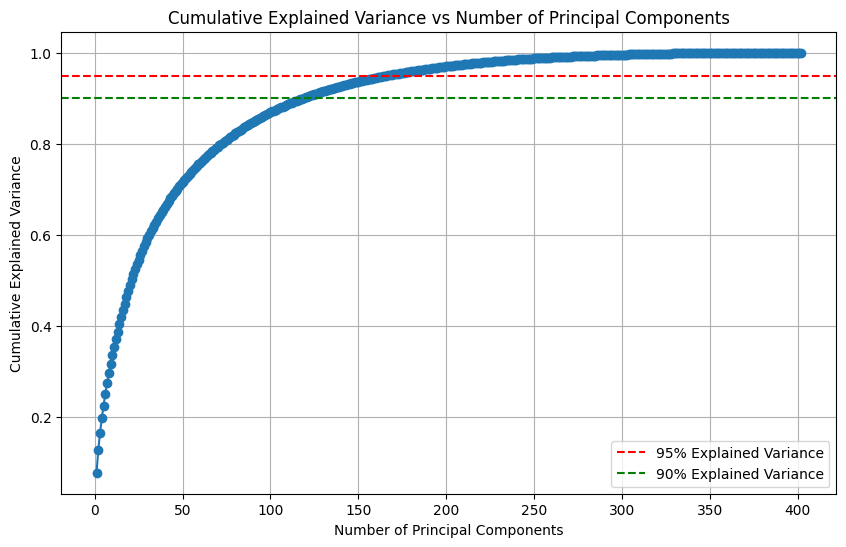

In [ ]:
file_path = "X_selected_with_target.csv"
data = pd.read_csv(file_path)

# Exclude irrelevant columns
exclude_columns = ["bad_flag"]
features = data.drop(columns=exclude_columns)

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Perform PCA with 200 components
max_components = min(features_scaled.shape[0], features_scaled.shape[1])
pca = PCA(n_components=max_components)
pca.fit(features_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = explained_variance.cumsum()

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_components + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance vs Number of Principal Components")
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Explained Variance")
plt.axhline(y=0.90, color='g', linestyle='--', label="90% Explained Variance")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

data = pd.read_csv("processed_dataset.csv") # put preprocessed dataset here

data = data.drop(columns=["account_number"])
X = data.iloc[:, 1:].values
y = data["bad_tag"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=256, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, X_test_tensor), batch_size=256, shuffle=False)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

input_dim = X_train.shape[1]
encoding_dim = 100
learning_rate = 0.001
epochs = 50

model = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch_features, _ in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_features)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss:.6f}")

model.eval()
with torch.no_grad():
    reconstruction_error = 0.0
    total_samples = 0
    for batch_features, _ in test_loader:
        outputs = model(batch_features)
        loss = criterion(outputs, batch_features)
        reconstruction_error += loss.item() * len(batch_features)
        total_samples += len(batch_features)

reconstruction_error /= total_samples
print(f"Reconstruction Error (MSE): {reconstruction_error:.6f}")
print(f"Percentage of Data Reconstructed: {(1 - reconstruction_error) * 100:.2f}%")

with torch.no_grad():
    X_train_encoded = model.encoder(X_train_tensor).numpy()
    X_test_encoded = model.encoder(X_test_tensor).numpy()

pd.DataFrame(X_train_encoded).to_csv("reduced_train.csv", index=False)
pd.DataFrame(X_test_encoded).to_csv("reduced_test.csv", index=False)


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

data = pd.read_csv("processed_dataset.csv") # put preproccesed dataset here

data = data.drop(columns=["account_number"])
X = data.iloc[:, 1:].values
y = data["bad_flag"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=256, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, X_test_tensor), batch_size=256, shuffle=False)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, dropout_rate=0.2):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

input_dim = X_train.shape[1]
encoding_dim = 100            # Reduced dimensionality
learning_rate = 0.001
epochs = 50
dropout_rate = 0.2

model = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim, dropout_rate=dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch_features, _ in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_features)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss:.6f}")

model.eval()
with torch.no_grad():
    reconstruction_error = 0.0
    total_samples = 0
    for batch_features, _ in test_loader:
        outputs = model(batch_features)
        loss = criterion(outputs, batch_features)
        reconstruction_error += loss.item() * len(batch_features)
        total_samples += len(batch_features)

reconstruction_error /= total_samples
print(f"Reconstruction Error (MSE): {reconstruction_error:.6f}")
print(f"Percentage of Data Reconstructed: {(1 - reconstruction_error) * 100:.2f}%")

with torch.no_grad():
    X_train_encoded = model.encoder(X_train_tensor).numpy()
    X_test_encoded = model.encoder(X_test_tensor).numpy()

pd.DataFrame(X_train_encoded).to_csv("reduced_train.csv", index=False)
pd.DataFrame(X_test_encoded).to_csv("reduced_test.csv", index=False)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Epoch 1/50, Loss: nan
Epoch 2/50, Loss: nan
Epoch 3/50, Loss: nan
Epoch 4/50, Loss: nan
Epoch 5/50, Loss: nan
Epoch 6/50, Loss: nan
Epoch 7/50, Loss: nan
Epoch 8/50, Loss: nan
Epoch 9/50, Loss: nan
Epoch 10/50, Loss: nan
Epoch 11/50, Loss: nan
Epoch 12/50, Loss: nan
Epoch 13/50, Loss: nan


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Load the dataset
data = pd.read_csv("processed_dataset.csv")

data = data.drop(columns=["account_number"])  # Exclude account number
X = data.iloc[:, 1:].values  # Features (excluding 'bad_tag')
y = data["bad_flag"].values   # Target

# Handle NaN and infinite values
data = data.fillna(data.mean())  # Fill NaN with column mean
data = data.replace([np.inf, -np.inf], np.nan).fillna(data.mean())  # Handle infinite values

# Drop constant columns
constant_columns = data.columns[data.nunique() <= 1]
data = data.drop(columns=constant_columns)

# Summary statistics
print(data.describe())  # Check for columns with zero variance or unusual values

# Check for NaN and infinite values
print("NaN values per column:")
print(data.isna().sum())

print("Infinite values per column:")
print((data == np.inf).sum() + (data == -np.inf).sum())

# Check for constant columns (zero variance)
print("Columns with zero variance:")
print(data.loc[:, (data.nunique() <= 1)].columns)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X + 1e-8)  # Add a small value to avoid division by zero

# Train-test split
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# DataLoader for batching
train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=256, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, X_test_tensor), batch_size=256, shuffle=False)

# Define the Autoencoder with an additional layer and dropout regularization
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, dropout_rate=0.2):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Dropout for regularization
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, input_dim),
            nn.Sigmoid()  # Output scaled between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Hyperparameters
input_dim = X_train.shape[1]  # Number of input features
encoding_dim = 100            # Reduced dimensionality
learning_rate = 0.0001        # Reduced learning rate for stability
epochs = 50
dropout_rate = 0.2

# Initialize the model
model = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim, dropout_rate=dropout_rate)

# Initialize weights using He initialization
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        nn.init.constant_(m.bias, 0)

model.apply(initialize_weights)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with gradient clipping
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch_features, _ in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_features)
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss:.6f}")

# Evaluation: Calculate % reconstruction error
model.eval()
with torch.no_grad():
    reconstruction_error = 0.0
    total_samples = 0
    for batch_features, _ in test_loader:
        outputs = model(batch_features)
        loss = criterion(outputs, batch_features)
        reconstruction_error += loss.item() * len(batch_features)
        total_samples += len(batch_features)

reconstruction_error /= total_samples
print(f"Reconstruction Error (MSE): {reconstruction_error:.6f}")
print(f"Percentage of Data Reconstructed: {(1 - reconstruction_error) * 100:.2f}%")

# Dimensionality reduction
with torch.no_grad():
    X_train_encoded = model.encoder(X_train_tensor).numpy()
    X_test_encoded = model.encoder(X_test_tensor).numpy()

# Save reduced datasets
pd.DataFrame(X_train_encoded).to_csv("reduced_train.csv", index=False)
pd.DataFrame(X_test_encoded).to_csv("reduced_test.csv", index=False)


           bad_flag  onus_attribute_1  transaction_attribute_1  \
count  96806.000000      9.680600e+04             96806.000000   
mean       0.014173      1.542391e+05                 9.570769   
std        0.118203      1.487496e+05              1301.803184   
min        0.000000      2.500000e+04                 0.000000   
25%        0.000000      7.200000e+04                 0.000000   
50%        0.000000      1.500000e+05                 0.000000   
75%        0.000000      1.542391e+05                 9.570769   
max        1.000000      2.800000e+06            398936.791000   

       transaction_attribute_2  transaction_attribute_3  \
count             96806.000000             96806.000000   
mean                  0.002207                 4.092854   
std                   0.102530               259.317693   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.00

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Epoch 1/50, Loss: nan
Epoch 2/50, Loss: nan


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from supervised.automl import AutoML
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss
from sklearn.model_selection import train_test_split

# Load the data
df = pd.read_csv("processed_dataset.csv")

# Separate features and target
X = df.drop(['acc_number', 'bad_flag'], axis=1)  # Remove acc_number and target
y = df['bad_flag']  # Target variable

# Split the data to properly evaluate probabilities
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize AutoML
automl = AutoML(
    # General settings
    mode="Compete",
    ml_task="binary_classification",
    eval_metric="logloss",  # Better for probability estimation

    # Validation settings
    validation_strategy={
        "validation_type": "kfold",
        "k_folds": 5,
        "shuffle": True,
        "stratify": True,
    },

    # Algorithms to use - focusing on those good at probability estimation
    algorithms=["LightGBM", "Xgboost", "CatBoost", "Neural Network"],

    # Stack models
    stack_models=True,
    stack_types=["LightGBM", "CatBoost"],

    # Features engineering
    features_selection=True,
    feature_selection_strategy="shuffle",

    # Training settings
    total_time_limit=3600,  # 1 hour
    explain_level=2,

    # Output settings
    results_path="AutoML_Probabilities",
)

# Train the AutoML
automl.fit(X_train, y_train)

# Get model leaderboard
print("Models Leaderboard:")
print(automl.leaderboard())

# Get probability predictions
train_probas = automl.predict_proba(X_train)
test_probas = automl.predict_proba(X_test)

# Calculate probability-based metrics
def evaluate_probabilities(y_true, y_pred_proba):
    """Evaluate probability predictions using multiple metrics"""
    # Get the probability of class 1 (default)
    if isinstance(y_pred_proba, np.ndarray) and y_pred_proba.ndim == 2:
        y_pred_proba = y_pred_proba[:, 1]

    results = {
        'ROC AUC': roc_auc_score(y_true, y_pred_proba),
        'Brier Score': brier_score_loss(y_true, y_pred_proba),
        'Log Loss': log_loss(y_true, y_pred_proba)
    }
    return results

# Evaluate on both train and test sets
print("\nTraining Set Metrics:")
train_metrics = evaluate_probabilities(y_train, train_probas)
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nTest Set Metrics:")
test_metrics = evaluate_probabilities(y_test, test_probas)
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

# Create a DataFrame with probabilities for analysis
results_df = pd.DataFrame({
    'true_label': y_test,
    'default_probability': test_probas[:, 1] if isinstance(test_probas, np.ndarray) and test_probas.ndim == 2 else test_probas
})

# Show probability distribution statistics
print("\nProbability Distribution Statistics:")
print(results_df['default_probability'].describe())

# Save predictions
results_df.to_csv("default_probabilities.csv", index=False)

# To make probability predictions on new data:
# new_probas = automl.predict_proba(new_data)

ImportError: cannot import name 'interp' from 'scipy' (/usr/local/lib/python3.10/dist-packages/scipy/__init__.py)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, mean_squared_error
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

# Step 1: Load and preprocess the dataset
file_path = 'processed_dataset.csv'

# Load the dataset
df = pd.read_csv(file_path)

# Drop rows with all NaNs in feature columns (columns 3 onward)
df_filtered = df.loc[~df.iloc[:, 2:].isnull().all(axis=1)]

# Separate features and target
X = df_filtered.iloc[:, 2:]  # Feature columns
y = df_filtered.iloc[:, 1]   # Target column (bad_tag)

# Handle missing values using mean imputation
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Step 2: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

# Step 3: Train Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(X_train)
iso_scores = -iso_forest.decision_function(X_test)  # Convert to positive scores for consistency
iso_probabilities = (iso_scores - iso_scores.min()) / (iso_scores.max() - iso_scores.min())  # Normalize to [0, 1]

# Step 4: Train Autoencoder
# Define the autoencoder model
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train autoencoder only on non-default samples
X_train_normal = X_train[y_train == 0]
autoencoder.fit(X_train_normal, X_train_normal, epochs=50, batch_size=32, shuffle=True, validation_split=0.2, verbose=0)

# Calculate reconstruction errors
X_test_reconstructed = autoencoder.predict(X_test)
reconstruction_errors = np.mean((X_test - X_test_reconstructed) ** 2, axis=1)
auto_probabilities = (reconstruction_errors - reconstruction_errors.min()) / (reconstruction_errors.max() - reconstruction_errors.min())  # Normalize to [0, 1]

# Step 5: Combine probabilities
combined_probabilities = (iso_probabilities + auto_probabilities) / 2  # Average probabilities

# Step 6: Evaluate the regression output
auc_score = roc_auc_score(y_test, combined_probabilities)
mse = mean_squared_error(y_test, combined_probabilities)

print(f"AUC-ROC Score: {auc_score}")
print(f"Mean Squared Error: {mse}")

# Display the combined probabilities
results = pd.DataFrame({
    "True_Label": y_test,
    "Predicted_Probability": combined_probabilities
})
print(results.head())

# Save results to a CSV
results.to_csv("predicted_probabilities.csv", index=False)


908/908 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
AUC-ROC Score: 0.6076402476864177
Mean Squared Error: 0.02551394829875342
       True_Label  Predicted_Probability
8423            0               0.196610
58652           0               0.029733
6290            0               0.074848
15712           0               0.018282
4354            0               0.069701


In [ ]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


In [ ]:
def load_and_preprocess_data(file_path):
    # Load the data
    df = pd.read_csv(file_path)

    # Separate features from acc_no and bad_tag
    acc_numbers = df.iloc[:, 0]
    bad_tags = df.iloc[:, 1]
    features = df.iloc[:, 2:]

    # Scale the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    return scaled_features, bad_tags, acc_numbers, scaler

# File path to your CSV (replace with your actual file path in Colab)
file_path = 'reduced_dataset.csv'

# Load and preprocess the data
X, y, acc_numbers, scaler = load_and_preprocess_data(file_path)


In [ ]:
def create_autoencoder(input_dim, encoding_dim=50):
    # Encoder
    input_layer = layers.Input(shape=(input_dim,))

    # Multiple encoding layers with decreasing dimensions
    encoded = layers.Dense(256, activation='relu')(input_layer)
    encoded = layers.BatchNormalization()(encoded)
    encoded = layers.Dense(128, activation='relu')(encoded)
    encoded = layers.BatchNormalization()(encoded)
    encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

    # Decoder
    decoded = layers.Dense(128, activation='relu')(encoded)
    decoded = layers.BatchNormalization()(decoded)
    decoded = layers.Dense(256, activation='relu')(decoded)
    decoded = layers.BatchNormalization()(decoded)
    decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

    # Create autoencoder model
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)

    return autoencoder, encoder


In [ ]:
def plot_training_history(history):
    """Plot training and validation loss over epochs"""
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Autoencoder Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.show()


Testing encoding dimension: 10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Testing encoding dimension: 30
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Testing encoding dimension: 50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Testing encoding dimension: 70
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Testing encoding dimension: 100
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


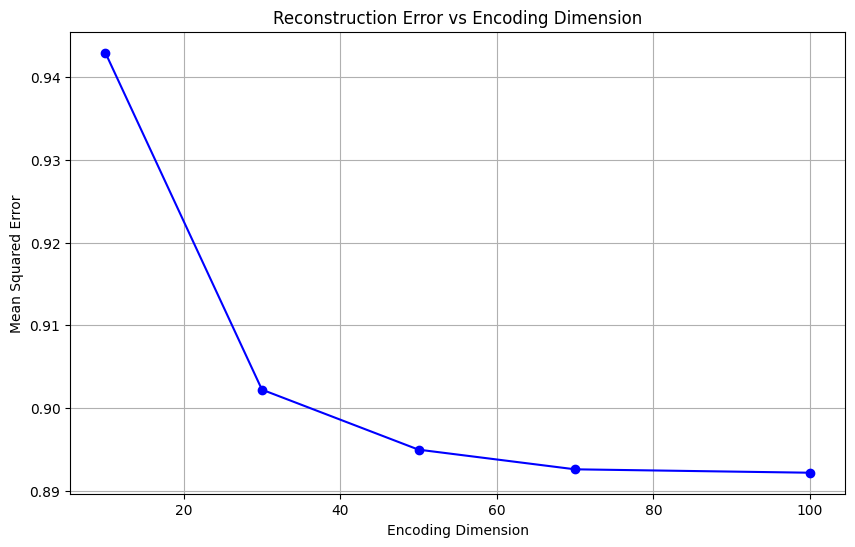

In [ ]:
def plot_dimension_analysis(X, input_dim, dim_range=[10, 30, 50, 70, 100]):
    """Plot reconstruction error vs encoding dimension"""
    reconstruction_errors = []

    for dim in dim_range:
        print(f"Testing encoding dimension: {dim}")
        autoencoder, _ = create_autoencoder(input_dim, encoding_dim=dim)
        autoencoder.compile(optimizer='adam', loss='mse')

        # Train with fewer epochs for quick analysis
        X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)
        autoencoder.fit(
            X_train, X_train,
            epochs=20,
            batch_size=32,
            validation_data=(X_val, X_val),
            verbose=0
        )

        # Calculate reconstruction error
        reconstructed = autoencoder.predict(X_val)
        mse = mean_squared_error(X_val, reconstructed)
        reconstruction_errors.append(mse)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(dim_range, reconstruction_errors, 'bo-')
    plt.title('Reconstruction Error vs Encoding Dimension')
    plt.xlabel('Encoding Dimension')
    plt.ylabel('Mean Squared Error')
    plt.grid(True)
    plt.show()

    return dim_range, reconstruction_errors

# Analyze different encoding dimensions
dims, errors = plot_dimension_analysis(X, X.shape[1])


Epoch 1/100
840/840 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.9783 - val_loss: 0.9390
Epoch 2/100
840/840 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.8576 - val_loss: 0.9177
Epoch 3/100
840/840 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.7874 - val_loss: 0.9097
Epoch 4/100
840/840 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.7994 - val_loss: 0.9057
Epoch 5/100
840/840 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.8469 - val_loss: 0.9036
Epoch 6/100
840/840 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.8010 - val_loss: 0.9014
Epoch 7/100
840/840 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.7846 - val_loss: 0.9009
Epoch 8/100
840/840 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.7812 - val_loss: 0.8995
Epoch 9/100
840/840 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.8254 - val_loss: 0.8987
Epoch 10/100
840/840 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 0.7695 - val_loss: 0.8979
Epoch 11/100
840/840 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.7306 - val_loss: 0.8978
Epoch 12/100
840/84

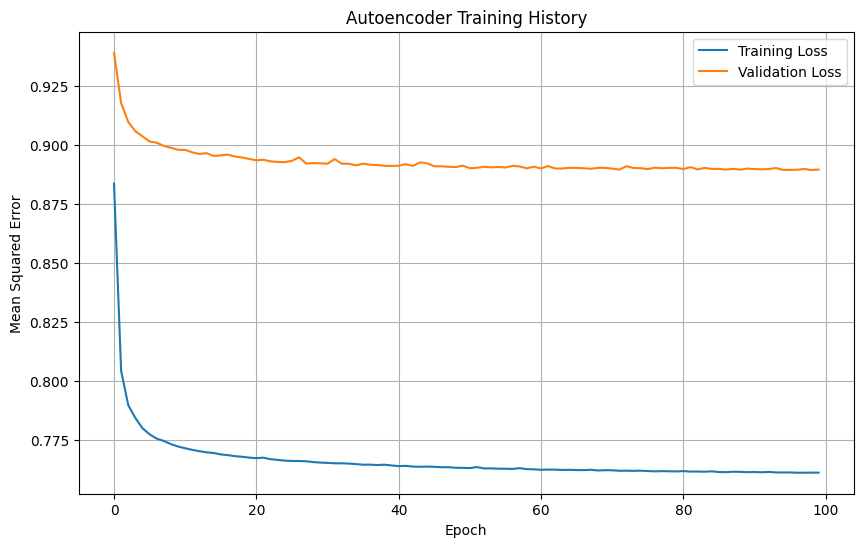

In [ ]:
def train_autoencoder(X, encoding_dim=80, epochs=100, batch_size=32):
    # Create and compile the autoencoder
    input_dim = X.shape[1]
    autoencoder, encoder = create_autoencoder(input_dim, encoding_dim)

    autoencoder.compile(optimizer='adam', loss='mse')

    # Split data into train and validation sets
    X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

    # Train the autoencoder
    history = autoencoder.fit(
        X_train, X_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_data=(X_val, X_val)
    )

    # Calculate reconstruction error
    reconstructed_train = autoencoder.predict(X_train)
    reconstructed_val = autoencoder.predict(X_val)

    train_mse = mean_squared_error(X_train, reconstructed_train)
    val_mse = mean_squared_error(X_val, reconstructed_val)

    print("\nReconstruction Error Analysis:")
    print(f"Training MSE: {train_mse:.6f}")
    print(f"Validation MSE: {val_mse:.6f}")

    # Plot training history
    plot_training_history(history)

    return autoencoder, encoder, history

# Train the autoencoder
autoencoder, encoder, history = train_autoencoder(X, encoding_dim=50)


In [ ]:
# Get encoded features
encoded_features = encoder.predict(X)

# Create DataFrame with reduced features
encoded_df = pd.DataFrame(
    encoded_features,
    columns=[f'feature_{i}' for i in range(encoded_features.shape[1])]
)

# Add acc_numbers and bad_tags back
final_df = pd.concat([
    pd.Series(acc_numbers).reset_index(drop=True),
    pd.Series(y).reset_index(drop=True),
    encoded_df
], axis=1)

# Save reduced dataset
final_df.to_csv('reduced_credit_data.csv', index=False)

# Display first few rows of the final DataFrame
final_df.head()


1049/1049 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


,onus_attribute_2,onus_attribute_17,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,0.000000,0.000000,9.441407,9.699624,24.175051,15.851023,9.455946,9.365479,8.861164,17.480734,...,18.026560,13.237745,7.245000,15.380562,9.748929,10.157167,12.726661,11.471971,13.359776,16.470102
1,0.493875,0.353684,10.947942,20.936708,10.540429,13.650601,5.226822,19.169510,6.382273,19.295313,...,24.520487,8.239327,14.934711,21.210688,29.259857,12.872231,22.402340,16.161583,7.830848,12.076866
2,0.430024,0.362633,12.774279,12.259825,12.959802,21.741795,9.843220,16.116470,13.237988,19.722816,...,19.807180,14.147631,27.297937,14.260709,17.370358,10.285337,11.836819,9.918354,14.847259,20.793682
3,0.014543,0.064999,10.617887,20.755379,19.042366,23.245316,11.547822,9.751687,17.586020,22.340841,...,19.336744,12.730539,11.739282,10.513484,14.445042,12.011401,14.894113,11.346084,6.077115,11.342583
4,0.002247,0.000749,3.816742,19.532970,16.681868,19.508522,12.510806,15.804230,16.484274,9.552011,...,12.056848,8.240899,10.643905,22.507385,19.211533,7.241680,4.903299,8.838300,12.864491,27.206957


from matplotlib import pyplot as plt
_df_0['onus_attribute_2'].plot(kind='hist', bins=20, title='onus_attribute_2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['onus_attribute_17'].plot(kind='hist', bins=20, title='onus_attribute_17')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['feature_0'].plot(kind='hist', bins=20, title='feature_0')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['feature_1'].plot(kind='hist', bins=20, title='feature_1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='onus_attribute_2', y='onus_attribute_17', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='onus_attribute_17', y='feature_0', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='feature_0', y='feature_1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='feature_1', y='feature_2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['onus_attribute_2'].plot(kind='line', figsize=(8, 4), title='onus_attribute_2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['onus_attribute_17'].plot(kind='line', figsize=(8, 4), title='onus_attribute_17')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['feature_0'].plot(kind='line', figsize=(8, 4), title='feature_0')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['feature_1'].plot(kind='line', figsize=(8, 4), title='feature_1')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
data=pd.read_csv('/content/predictions_ensemble (1).csv')

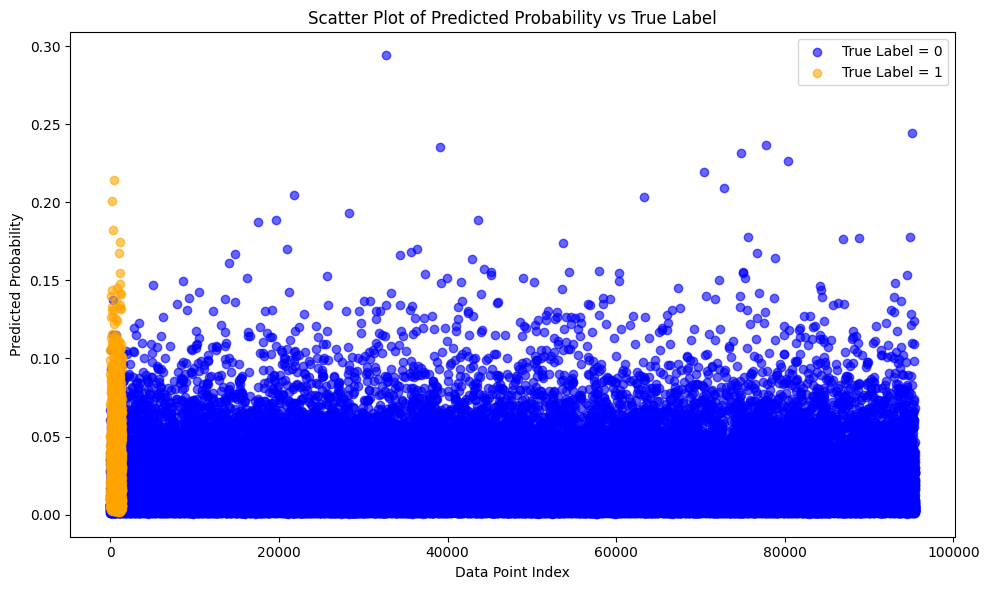

In [ ]:
# Plot the data points
plt.figure(figsize=(10, 6))
plt.scatter(range(len(data[data["target"] == 0])),
            data[data["target"] == 0]["prediction"],
            color='blue', label='True Label = 0', alpha=0.6)
plt.scatter(range(len(data[data["target"] == 1])),
            data[data["target"] == 1]["prediction"],
            color='orange', label='True Label = 1', alpha=0.6)

# Adding labels and title
plt.xlabel('Data Point Index')
plt.ylabel('Predicted Probability')
plt.title('Scatter Plot of Predicted Probability vs True Label')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df=pd.read_csv('/content/final_predictions.csv')

In [ ]:
df.head()

,Unnamed: 0,Predicted_Prob
0,0,8.040751e-11
1,1,9.682730e-11
2,2,4.351557e-18
3,3,2.133565e-10
4,4,5.040338e-12


In [ ]:
df2=pd.read_csv('/content/validation_data_to_be_shared.csv')

In [ ]:
df2.head()

,account_number,onus_attribute_1,transaction_attribute_1,transaction_attribute_2,transaction_attribute_3,transaction_attribute_4,transaction_attribute_5,transaction_attribute_6,transaction_attribute_7,transaction_attribute_8,...,bureau_enquiry_47,bureau_enquiry_48,bureau_enquiry_49,bureau_enquiry_50,onus_attribute_43,onus_attribute_44,onus_attribute_45,onus_attribute_46,onus_attribute_47,onus_attribute_48
0,100001,34000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,100003,130000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN
3,100004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,53000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
result = pd.concat([df, df2[['account_number']].reset_index(drop=True)], axis=1)


In [ ]:
result.to_csv('result_final.csv',index=False)

In [ ]:
result.head()

,Unnamed: 0,Predicted_Prob,account_number
0,0,8.040751e-11,100001
1,1,9.682730e-11,100002
2,2,4.351557e-18,100003
3,3,2.133565e-10,100004
4,4,5.040338e-12,100005
